In [1]:
# Environment and cache setup
import os
from pathlib import Path
import sys

# Prefer absolute paths on the cluster
PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'pancreas_baseline'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

# Ensure local package imports work
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Set environment variables for local cache directories
os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_baseline
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_baseline/model_outputs


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output



/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [4]:
# Paths and dataset config
# Correct pancreas dataset path provided by user
in_dataset_path = DATA_ROOT / 'data' / 'pancreas_cancer_with_celltypes.h5ad'
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / (dataset_name + '_full_model_v1')).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

# Placeholders; will be finalized after inspection cells
gene_col = 'gene_symbols'
batch_col = 'sample'     # will correct after inspection
label_col = 'cell_type'  # will correct after inspection
layer_key = 'X'

# Tag this run to avoid overwriting previous subset outputs
RUN_TAG = 'full'

# Geneformer model paths
model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V1-10M').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/pancreas_cancer_with_celltypes.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_full_model_v1
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [5]:
# Create Geneformer instance and load model/vocab
batch_size = 2
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-20 23:33:38 | Using device cuda


INFO     | 2025-08-20 23:33:39 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M


In [6]:

# Subset is disabled for this run. We will use the full dataset.
MAKE_SUBSET = False

In [7]:
# Load and preprocess data to h5ad for tokenizer (avoid loom)
inp = data.InputData(adata_dataset_path=str(in_dataset_path))

inp.preprocess_data(
    gene_col=gene_col,
    model_type='geneformer',
    save_ext='h5ad',
    gene_name_id_dict=geneform.gene_name_id,
    preprocessed_path=str(preprocessed_path)
)

h5_path = preprocessed_path / f'{dataset_name}_full_model_v1.h5ad'
print('h5_path:', h5_path, 'exists:', h5_path.exists())


INFO     | 2025-08-20 23:33:42 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/pancreas_cancer_with_celltypes.h5ad
WARNING  | 2025-08-20 23:34:19 | Gene names not found in var columns. Using index instead.
INFO     | 2025-08-20 23:34:32 | Matched 94.27% genes (18508/19634) genes in vocabulary of size 63675.


h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_full_model_v1/pancreas_cancer_with_celltypes_full_model_v1.h5ad exists: False


In [8]:
# Safety: ensure the tokenizer column names exist in the h5ad before tokenization
# Some crashes happen if cell_type column is missing or renamed in the saved preprocessed file
import scanpy as sc
pfile = str(preprocessed_path / f'{dataset_name}.h5ad')

ad_tmp = sc.read(pfile)
# Guarantee adata.obs has 'cell_type' for tokenizer mapping
if 'cell_type' not in ad_tmp.obs.columns and label_col in ad_tmp.obs.columns:
    ad_tmp.obs['cell_type'] = ad_tmp.obs[label_col].astype(str).values
    print("Added 'cell_type' column from:", label_col)

# Keep row order column if missing (used later)
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values

ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_full_model_v1/pancreas_cancer_with_celltypes.h5ad


In [11]:
# Tokenize to HF Dataset on disk and persist

geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(preprocessed_path),
    cell_type_col=label_col
)

# TRUNCATION - Applied immediately after tokenization
print("=== APPLYING TRUNCATION TO TOKENIZED SEQUENCES ===")

# Truncate sequences to 2048 tokens to fit model limits
def truncate_sequences(example):
    # Force all sequences to be exactly 2048 tokens
    if len(example["input_ids"]) > 2048:
        example["input_ids"] = example["input_ids"][:2048]
    elif len(example["input_ids"]) < 2048:
        # Pad with zeros to reach 2048
        example["input_ids"] = example["input_ids"] + [0] * (2048 - len(example["input_ids"]))
    
    example["length"] = 2048  # Always 2048
    return example

print(f"Original dataset size: {len(geneform.tokenized_dataset)}")
if len(geneform.tokenized_dataset) > 0:
    print(f"Sample input_ids length before truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
    if 'length' in geneform.tokenized_dataset[0]:
        print(f"Sample length field before truncation: {geneform.tokenized_dataset[0]['length']}")

# Apply truncation
print("Applying truncation...")
geneform.tokenized_dataset = geneform.tokenized_dataset.map(truncate_sequences, num_proc=1)

if len(geneform.tokenized_dataset) > 0:
    print(f"Sample input_ids length after truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
    print(f"Sample length field after truncation: {geneform.tokenized_dataset[0]['length']}")

# Verify all sequences are within limit
max_length = max([len(example['input_ids']) for example in geneform.tokenized_dataset])
print(f"Maximum sequence length after truncation: {max_length}")
if max_length > 2048:
    print("⚠️ WARNING: Some sequences are still longer than 2048!")
else:
    print("✅ All sequences are ≤ 2048 tokens")

# Avoid deletion issues by using timestamped directory
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
dataset_dir = preprocessed_path / f'{dataset_name}_full_model_v1_{timestamp}.dataset'
print(f'Using timestamped dataset directory: {dataset_dir}')

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Successfully saved truncated tokenized dataset to disk.')
except Exception as e:
    print('Error saving to disk:', e)
    # Fallback: try saving with different name
    dataset_dir_fallback = preprocessed_path / f'{dataset_name}_truncated_fallback.dataset'
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir_fallback))
    print(f'Saved truncated dataset to fallback location: {dataset_dir_fallback}')
    dataset_dir = dataset_dir_fallback

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name,
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': label_col,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}_full_model_v1_{timestamp}.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'{dataset_name}.dataset')
print('Archived tokenized dataset to:', archive_path)

WARNING  | 2025-08-21 00:25:36 | using h5ad file. This sometimes causes issues. If not working try with loom.


Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_full_model_v1/pancreas_cancer_with_celltypes.h5ad
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_full_model_v1/pancreas_cancer_with_celltypes.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Number of cells: 224988
Sample input_ids length: 3432
=== APPLYING TRUNCATION TO TOKENIZED SEQUENCES ===
Original dataset size: 224988
Sample input_ids length before truncation: 3434
Sample length field before truncation: 3434
Applying truncation...
Sample input_ids length after truncation: 2048
Sample length field after truncation: 2048
Maximum sequence length after truncation: 2048
✅ All sequences are ≤ 2048 tokens
Using timestamped dataset directory: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_full_model_v1/pancreas_cancer_with_celltypes_full

In [12]:
# Load back the tokenized dataset (for demonstration / future runs)
geneform.load_tokenized_dataset(str(dataset_dir))

# Extract embeddings (second-to-last layer)
geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)

# Minimal evaluation objects
eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key=label_col,
    batch_key=batch_col
)

eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))

# Light-weight evaluation (subsample)
eval_pred.evaluate(n_cells=500, save_rankings=True)
eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')


Geneformer (extracting embeddings): 100%|██████████| 112494/112494 [56:25<00:00, 33.22it/s] 
DEBUG    | 2025-08-21 01:36:19 | Extracting output from 500 cells
WARNING  | 2025-08-21 01:36:30 | adata_ has 224988 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-21 01:36:30 | Computing metrics for cell_type
DEBUG    | 2025-08-21 01:36:35 | NMI_cluster/label: 0.0613
ARI_cluster/label: 0.0053
ASW_label: 0.2906
graph_conn: 0.3553
ASW_batch: 0.3262
ASW_label/batch: 0.6495
PCR_batch: 0.2576
avg_bio: 0.1191
DEBUG    | 2025-08-21 01:36:35 | NMI_cluster/label for cell_type: 0.06128829679154663
DEBUG    | 2025-08-21 01:36:35 | ARI_cluster/label for cell_type: 0.0052955246140810215
DEBUG    | 2025-08-21 01:36:35 | ASW_label for cell_type: 0.2906407117843628
DEBUG    | 2025-08-21 01:36:35 | graph_conn for cell_type: 0.3552753783866756
DEBUG    | 2025-08-21 01:36:35 | ASW_batch for cell_type: 0.32621464133262634
DEBUG    | 2025-08-21 01:36:35 | ASW_label/batch for cell_type: 0.6494793891906738

,metric,label,value
0,NMI_cluster/label,cell_type,0.061288
1,ARI_cluster/label,cell_type,0.005296
2,ASW_label,cell_type,0.290641
3,graph_conn,cell_type,0.355275
4,ASW_batch,cell_type,0.326215
5,ASW_label/batch,cell_type,0.649479
6,PCR_batch,cell_type,0.257591
7,avg_bio,cell_type,0.119075


In [13]:
# Ensemble evaluation and saving in LangCell-like format
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col=label_col,
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V1-10M',
    'dataset_name': dataset_name,
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_pancreas_results_model_v1_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

# Save per-alpha metrics to CSV
import pandas as pd
rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_pancreas_metrics_model_v1_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-21 01:36:35 | Initialized GeneformerEnsembleMetrics with 224988 cells and 18 classes
INFO     | 2025-08-21 01:36:35 | Classes: ['Adipocyte', 'B_cell', 'Dendritic', 'Endocrine', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Malignant', 'Mast', 'Myocyte', 'NK_cell', 'Neuron', 'Neutrophil', 'Pericyte', 'Plasma', 'Schwann', 'T_cell']
INFO     | 2025-08-21 01:36:35 | Embedding shape: (224988, 256)
INFO     | 2025-08-21 01:36:35 | Input rankings length: 224988
INFO     | 2025-08-21 01:36:35 | Output rankings length: 224988


INFO     | 2025-08-21 01:36:36 | Evaluated embedding_only (α=0.0): Accuracy=0.037, F1=0.049, AUC-ROC=0.599


alpha=0.0: F1=0.049, AUC=0.599, Acc=0.037


INFO     | 2025-08-21 01:36:37 | Evaluated embedding_only (α=0.1): Accuracy=0.037, F1=0.049, AUC-ROC=0.599


alpha=0.1: F1=0.049, AUC=0.599, Acc=0.037


INFO     | 2025-08-21 01:36:38 | Evaluated embedding_only (α=0.3): Accuracy=0.037, F1=0.049, AUC-ROC=0.599


alpha=0.3: F1=0.049, AUC=0.599, Acc=0.037


INFO     | 2025-08-21 01:36:39 | Evaluated embedding_only (α=0.5): Accuracy=0.037, F1=0.049, AUC-ROC=0.599


alpha=0.5: F1=0.049, AUC=0.599, Acc=0.037


INFO     | 2025-08-21 01:36:41 | Evaluated embedding_only (α=0.7): Accuracy=0.037, F1=0.049, AUC-ROC=0.599


alpha=0.7: F1=0.049, AUC=0.599, Acc=0.037


INFO     | 2025-08-21 01:36:42 | Evaluated embedding_only (α=0.9): Accuracy=0.037, F1=0.049, AUC-ROC=0.599


alpha=0.9: F1=0.049, AUC=0.599, Acc=0.037


INFO     | 2025-08-21 01:36:43 | Evaluated embedding_only (α=1.0): Accuracy=0.037, F1=0.049, AUC-ROC=0.599


alpha=1.0: F1=0.049, AUC=0.599, Acc=0.037
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_baseline/model_outputs/geneformer_pancreas_results_model_v1_full.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_baseline/model_outputs/geneformer_pancreas_metrics_model_v1_full.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_baseline/model_outputs/geneformer_pancreas_confusion_matrix_model_v1_full.png


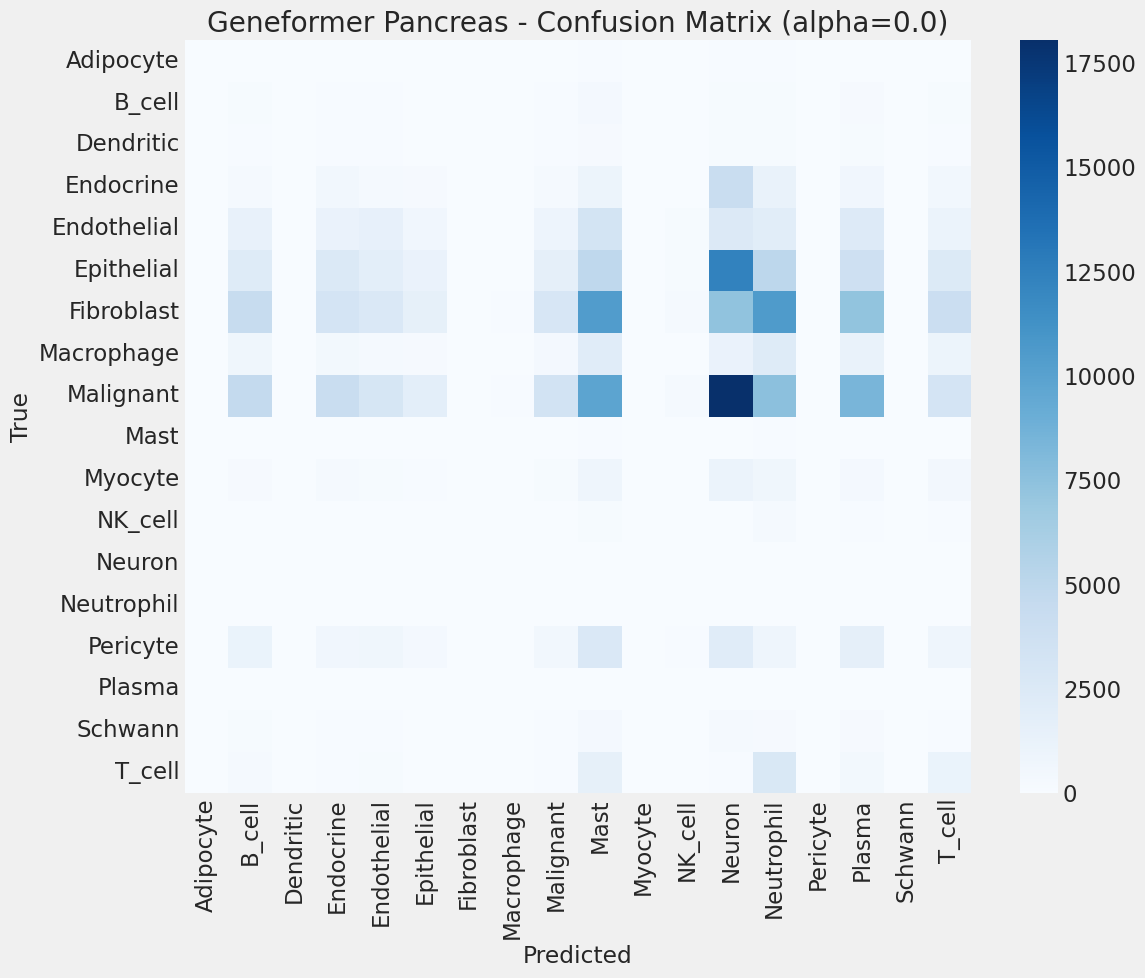

In [14]:
# Quick visualization: confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=em.class_names,
            yticklabels=em.class_names, ax=ax)
ax.set_title(f'Geneformer Pancreas - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_pancreas_confusion_matrix_model_v1_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


In [15]:
# Performance metrics summary
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
)

results_path = MODEL_OUT / f'geneformer_pancreas_results_model_v1_{RUN_TAG}.pt'

# Robust loader for PyTorch 2.6 safe loading
res = None
try:
    from torch.serialization import safe_globals, add_safe_globals
    try:
        with safe_globals([np.core.multiarray._reconstruct]):
            res = torch.load(results_path, map_location='cpu')
        print('Loaded results with safe_globals allowlist')
    except Exception:
        add_safe_globals([np.core.multiarray._reconstruct])
        res = torch.load(results_path, map_location='cpu')
        print('Loaded results after add_safe_globals')
except Exception as e:
    pass

if res is None:
    # Last resort: weights_only=False (only if file is trusted)
    res = torch.load(results_path, map_location='cpu', weights_only=False)
    print('Loaded results with weights_only=False')

# Extract base fields
model_name = res.get('model_name', 'UnknownModel')
dataset = res.get('dataset_name', 'UnknownDataset')
best_alpha = res.get('best_alpha', None)
class_names = list(res.get('class_names', []))

# Tensors to numpy
labels_t = res['labels']
preds_t = res['preds']
labels_np = labels_t.cpu().numpy() if hasattr(labels_t, 'cpu') else np.array(labels_t)
preds_np = preds_t.cpu().numpy() if hasattr(preds_t, 'cpu') else np.array(preds_t)

print(f'Model: {model_name}')
print(f'Dataset: {dataset}')
if best_alpha is not None:
    print(f'Best alpha (ensemble): {best_alpha}')

metrics = res.get('evaluation_metrics', None)
if metrics is not None:
    # Keys expected from earlier cell: accuracy, precision, recall, f1_score, auc_roc, avg_precision
    print('\nSaved evaluation metrics:')
    for k in ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'avg_precision']:
        if k in metrics:
            print(f'  {k}: {metrics[k]:.4f}')
else:
    # Compute a minimal set if not present
    acc = accuracy_score(labels_np, preds_np)
    prec, rec, f1, _ = precision_recall_fscore_support(labels_np, preds_np, average='macro', zero_division=0)
    print('\nComputed metrics (macro):')
    print(f'  accuracy: {acc:.4f}')
    print(f'  precision: {prec:.4f}')
    print(f'  recall: {rec:.4f}')
    print(f'  f1_score: {f1:.4f}')

# Detailed classification report
if class_names and len(class_names) > int(labels_np.max()):
    target_names = class_names
else:
    # Fallback to numeric class names
    n_classes = int(max(labels_np.max(), preds_np.max())) + 1
    target_names = [f'Class_{i}' for i in range(n_classes)]

print('\nClassification report:')
print(classification_report(labels_np, preds_np, target_names=target_names, digits=4))


Loaded results with weights_only=False
Model: Geneformer-V1-10M
Dataset: pancreas_cancer_with_celltypes
Best alpha (ensemble): 0.0

Saved evaluation metrics:
  accuracy: 0.0371
  precision: 0.1393
  recall: 0.0371
  f1_score: 0.0492
  auc_roc: 0.5992
  avg_precision: 0.0598

Classification report:
              precision    recall  f1-score   support

   Adipocyte     0.0000    0.0000    0.0000       531
      B_cell     0.0091    0.0935    0.0166      1573
   Dendritic     0.0000    0.0000    0.0000      1419
   Endocrine     0.0454    0.0638    0.0530      9801
 Endothelial     0.1389    0.0890    0.1085     17175
  Epithelial     0.1883    0.0320    0.0548     38208
  Fibroblast     0.0000    0.0000    0.0000     54935
  Macrophage     0.0649    0.0022    0.0042     10140
   Malignant     0.3120    0.0526    0.0901     64538
        Mast     0.0021    0.2847    0.0042       281
     Myocyte     0.0000    0.0000    0.0000      4711
     NK_cell     0.0062    0.0086    0.0072       92

Using in-memory em/preds objects
Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_baseline/model_outputs/geneformer_pancreas_umap_coords_model_v1_full.csv


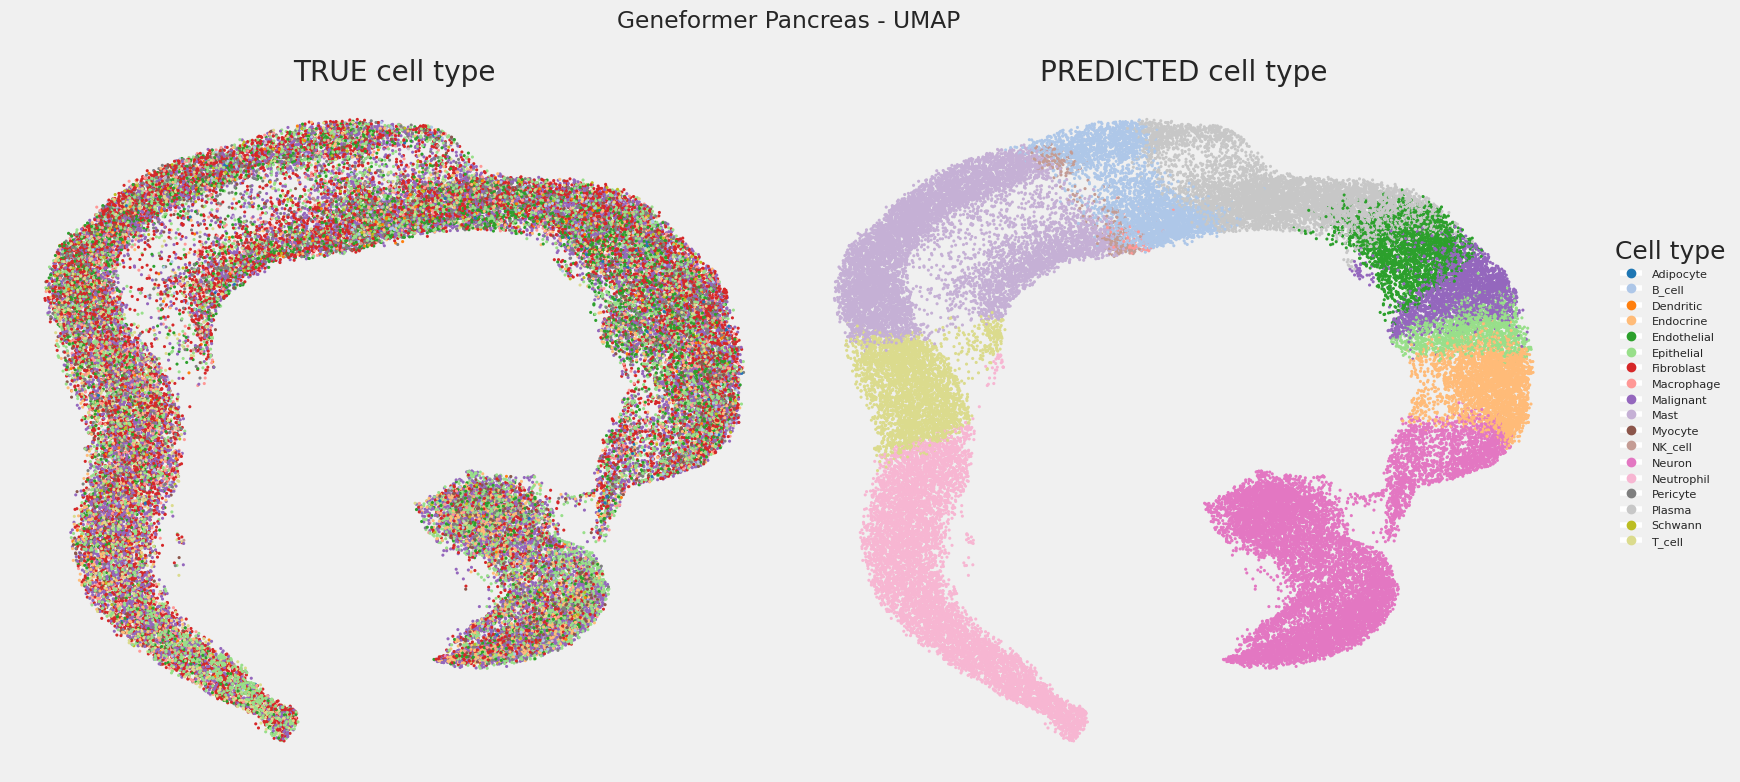

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_baseline/model_outputs/geneformer_pancreas_umap_true_pred_with_legend_model_v1_full.png


In [16]:
# UMAP of true vs predicted cell types from Geneformer zero-shot (with side legend like LangCell)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path

# Collect embeddings, labels, predictions, and class names
results_path = MODEL_OUT / f'geneformer_pancreas_results_model_v1_{RUN_TAG}.pt'

embeddings = None
labels_encoded = None
preds_arr = None
class_names = None

try:
    # Prefer in-memory objects if available
    embeddings = np.asarray(em.embeddings)
    labels_encoded = np.asarray(em.labels_encoded)
    class_names = list(em.class_names)
    preds_arr = np.asarray(preds)
    n_cells = embeddings.shape[0]
    assert labels_encoded.shape[0] == n_cells and preds_arr.shape[0] == n_cells
    print('Using in-memory em/preds objects')
except Exception as e:
    print('Falling back to saved results:', e)
    # Robust loader for PyTorch 2.6 safe loading
    res = None
    try:
        from torch.serialization import safe_globals, add_safe_globals
        try:
            with safe_globals([np.core.multiarray._reconstruct]):
                res = torch.load(results_path, map_location='cpu')
            print('Loaded results with safe_globals allowlist')
        except Exception:
            add_safe_globals([np.core.multiarray._reconstruct])
            res = torch.load(results_path, map_location='cpu')
            print('Loaded results after add_safe_globals')
    except Exception:
        pass
    if res is None:
        res = torch.load(results_path, map_location='cpu', weights_only=False)
        print('Loaded results with weights_only=False')
    def to_numpy(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        return np.array(x)
    embeddings = to_numpy(res['cell_embs'])
    labels_encoded = to_numpy(res['labels']).astype(int)
    preds_arr = to_numpy(res['preds']).astype(int)
    class_names = list(res['class_names'])

# Compute 2D embedding with UMAP; fallback to PCA if UMAP isn't available
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

# Prepare labels as names
class_names_arr = np.array(class_names, dtype=object)
true_names = class_names_arr[labels_encoded]
pred_names = class_names_arr[preds_arr]

# Optional: subsample points for plotting to keep figures responsive
PLOT_MAX = 50000
rng = np.random.RandomState(0)
if emb2d.shape[0] > PLOT_MAX:
    plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False))
else:
    plot_idx = np.arange(emb2d.shape[0])

# Build a consistent palette across plots
unique_levels = list(class_names)
if len(unique_levels) <= 20:
    pal_colors = sns.color_palette('tab20', n_colors=len(unique_levels))
else:
    pal_colors = sns.color_palette('hls', n_colors=len(unique_levels))
palette = dict(zip(unique_levels, pal_colors))

# Save coordinates for reproducibility (full set)
coords_path = MODEL_OUT / f'geneformer_pancreas_umap_coords_model_v1_{RUN_TAG}.csv'
coords_df = pd.DataFrame({
    'x': emb2d[:, 0],
    'y': emb2d[:, 1],
    'true': true_names,
    'pred': pred_names,
})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

# Combined figure with side legend (LangCell-like)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# TRUE labels plot
sns.scatterplot(
    ax=axes[0],
    x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1],
    hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False
)
axes[0].set_title(f'TRUE cell type')
axes[0].set_xlabel(''); axes[0].set_ylabel('')
axes[0].set_xticks([]); axes[0].set_yticks([])

# PREDICTED labels plot
sns.scatterplot(
    ax=axes[1],
    x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1],
    hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False
)
axes[1].set_title(f'PREDICTED cell type')
axes[1].set_xlabel(''); axes[1].set_ylabel('')
axes[1].set_xticks([]); axes[1].set_yticks([])

# Build legend handles once, place at right side
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in unique_levels
]
fig.legend(
    handles=handles,
    labels=unique_levels,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    frameon=False,
    fontsize='xx-small',
    title='Cell type'
)
fig.suptitle(f'Geneformer Pancreas - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_pancreas_umap_true_pred_with_legend_model_v1_{RUN_TAG}.png'
plt.tight_layout()
fig.savefig(combined_png, dpi=200, bbox_inches='tight')
plt.show()
print('Saved combined figure with legend to:', combined_png)


In [17]:
# LangCell-style UMAP using Scanpy on Geneformer embeddings
import numpy as np
import torch
import anndata as ad
import scanpy as sc
from pathlib import Path
import pandas as pd

# Prepare embeddings, labels, preds, class names (prefer in-memory)
results_path = MODEL_OUT / f'geneformer_pancreas_results_model_v1_{RUN_TAG}.pt'

embeddings = None
labels_encoded = None
preds_arr = None
class_names = None

try:
    embeddings = np.asarray(em.embeddings)
    labels_encoded = np.asarray(em.labels_encoded)
    class_names = list(em.class_names)
    preds_arr = np.asarray(preds)
    assert embeddings.shape[0] == labels_encoded.shape[0] == preds_arr.shape[0]
    print('Using in-memory em/preds objects')
except Exception as e:
    print('Falling back to saved results:', e)
    # Robust loader for PyTorch 2.6 safe loading
    res = None
    try:
        from torch.serialization import safe_globals, add_safe_globals
        try:
            with safe_globals([np.core.multiarray._reconstruct]):
                res = torch.load(results_path, map_location='cpu')
            print('Loaded results with safe_globals allowlist')
        except Exception:
            add_safe_globals([np.core.multiarray._reconstruct])
            res = torch.load(results_path, map_location='cpu')
            print('Loaded results after add_safe_globals')
    except Exception:
        pass
    if res is None:
        res = torch.load(results_path, map_location='cpu', weights_only=False)
        print('Loaded results with weights_only=False')
    def to_numpy(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        return np.array(x)
    embeddings = to_numpy(res['cell_embs'])
    labels_encoded = to_numpy(res['labels']).astype(int)
    preds_arr = to_numpy(res['preds']).astype(int)
    class_names = list(res['class_names'])

# Build AnnData and run Scanpy neighbors/UMAP like LangCell
adata = ad.AnnData(embeddings.astype(np.float32))
class_names_arr = np.array(class_names, dtype=object)
adata.obs['true'] = class_names_arr[labels_encoded]
adata.obs['pred'] = class_names_arr[preds_arr]

# LangCell-like parameters
sc.pp.neighbors(adata, use_rep='X', n_neighbors=80, metric='euclidean')
sc.tl.umap(adata, min_dist=0.5, random_state=0)

# Save coordinates
umap_coords = pd.DataFrame(
    adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2']
)
umap_coords['true'] = adata.obs['true'].to_numpy()
umap_coords['pred'] = adata.obs['pred'].to_numpy()
coords_csv = MODEL_OUT / f'geneformer_pancreas_umap_langcell_coords_model_v1_{RUN_TAG}.csv'
umap_coords.to_csv(coords_csv, index=False)
print('Saved LangCell-style UMAP coords to:', coords_csv)

# Plot using Scanpy's style and save
sc.settings.figdir = str(MODEL_OUT)
sc.settings.autoshow = False
sc.pl.umap(
    adata,
    color=['true', 'pred'],
    legend_fontsize='xx-small',
    size=5,
    show=False,
    save=f"_langcell_style_model_v1_{RUN_TAG}.png"
)
print('Saved LangCell-style UMAP figure to:', MODEL_OUT / f"umap_langcell_style_model_v1_{RUN_TAG}.png")


Using in-memory em/preds objects


... storing 'true' as categorical
... storing 'pred' as categorical


Saved LangCell-style UMAP coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_baseline/model_outputs/geneformer_pancreas_umap_langcell_coords_model_v1_full.csv
Saved LangCell-style UMAP figure to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_baseline/model_outputs/umap_langcell_style_model_v1_full.png
